In [15]:
include("../src/seismic.jl")
include("../src/cracks.jl")

using Plots; gr();

In [4]:
# # Mafic
# rho = 3030
# vp = 6.10
# vpvs = 1.66

# # intermediate
# rho = 2565 
# vp = 5.98
# vpvs = 1.66
    
# Felsic
rho = 2444 #kg/m3 
vp = 5.92 #km/s
vpvs = 1.57

1.57

In [5]:
# smegtite K and G from https://doi.org/10.1046/j.1365-246X.2003.02046.x 
K2 = 120000 # bar
G2 = 60000 # bar

60000

In [6]:
# Matrix properties
K1, G1 = ks_mu(rho, vp, vp/vpvs)

(393210.8164111053, 347492.3996916711)

In [7]:
# Volume of inclusions
C2 = .2

0.2

In [8]:
function inclusions(K1, G1, K2, G2, C2)
    A = G2/G1 - 1
    B = 1/3*(K2/K1 - G2/G1)
    R = 3*G1/(3*K1 + 4*G1)

    K0 = 1/(1/K1*(1+C2/3* (3+R*A)/(1+(1-R)*A+(3-4*R)*B) * (K1-K2)/K1)) # eq 20
    G0_innards = 2/(1+A/2) + 1/(1+(1+R)*(A/2)) + (1-4/3*R)*(A+3*B)/(1+(1-R)*A+(3-4*R)*B) + 
                2*(1+(3-R)*(A/4)+(3-4*R)*(B/2))/((1+(1+R)*(A/2))*(1+(1-R)*A+(3-4*R)*B))
    G0 = 1/(1/G1*(1+C2/5*G0_innards*((G1-G2)/G1)))
    return K0, G0
end

inclusions (generic function with 1 method)

In [ ]:
# Assume use of K0, G0 on right side of eqn are not typos

function G0_solver(K1, G1, K2, G2, C2)
    return function(G0)
        G0_innards = 2/(1+A/2) + 1/(1+(1+R)*(A/2)) + (1-4/3*R)*(A+3*B)/(1+(1-R)*A+(3-4*R)*B) + 
                2*(1+(3-R)*(A/4)+(3-4*R)*(B/2))/((1+(1+R)*(A/2))*(1+(1-R)*A+(3-4*R)*B))
        right_side = 1/(1/G1*(1+C2/5*G0_innards*((G1-G2)/G0)))
        return G0 - right_side # =0 for correct G0
    end 
end

function K0_solver(K1, G1, K2, G2, C2)
    return function(K0)
        right

In [60]:
# Assume use of K0, G0 on right side of eqn 20 and 21 are not typos
# Assume use of K0, G0 in eqs 8, 9, and 10 are matrix NOT mixture 

function G0_solver(K1, G1, K2, G2, C2, K0)
    return function(G0)
        A = G2/G1 - 1
        B = 1/3*(K2/K1 - G2/G1)
        R = 3*G0/(3*K0 + 4*G0)
        
        G0_innards = 2/(1+A/2) + 1/(1+(1+R)*(A/2)) + ((1-4/3*R)*(A+3*B))/(1+(1-R)*A+(3-4*R)*B) + 
                2*(1+(3-R)*(A/4)+(3-4*R)*(B/2))/((1+(1+R)*(A/2))*(1+(1-R)*A+(3-4*R)*B))
        right_side = 1/(1/G1*(1+C2/5*G0_innards*((G1-G2)/G0)))
        return G0 - right_side # =0 for correct G0
    end 
end

function K0_solver(K1, G1, K2, G2, C2)
    return function(K0)
        G0 = find_zero(G0_solver(K1, G1, K2, G2, C2, K0), G1)
        
        A = G2/G1 - 1
        B = 1/3*(K2/K1 - G2/G1)
        R = 3*G0/(3*K0 + 4*G0)
        
        right_side = 1/(1/K1*(1+C2/3* (3+R*A)/(1+(1-R)*A+(3-4*R)*B) * (K1-K2)/K0)) # eq 20
        return K0 - right_side
    end
end


function inclusions2(K1, G1, K2, G2, C2)

    K0 = find_zero(K0_solver(K1, G1, K2, G2, C2), K1)
    
    # Now that have K0, find G0
    G0 = find_zero(G0_solver(K1, G1, K2, G2, C2, K0), G1)
    
    return K0, G0
end

inclusions2 (generic function with 1 method)

In [61]:
x = K0_solver(K1, G1, K2, G2, C2)
x(20000)

-80982.75697491692

In [86]:
println("Matrix is $K1, $G1")
println("Inclusions are $K2, $G2")
inclusions2(K1, G1, K2, G2, 0.8)

Matrix is 393210.8164111053, 347492.3996916711
Inclusions are 120000, 60000


(0.0, -2.1915846212142297e-81)

In [62]:
# Young's modulus from bulk and sheer moduli
function E_from_KG(K, G)
    return 9*K*G/(G+3*K)
end

E_from_KG (generic function with 1 method)

In [63]:
n = 50
Cs = collect(LinRange(0,1,n))
Ks = zeros(n)
Gs = zeros(n);
E0s = zeros(n);

In [64]:
for i in 1:n
    Ks[i], Gs[i] = inclusions2(K1, G1, K2, G2, Cs[i])
    E0s[i] = E_from_KG(Ks[i], Gs[i])
end

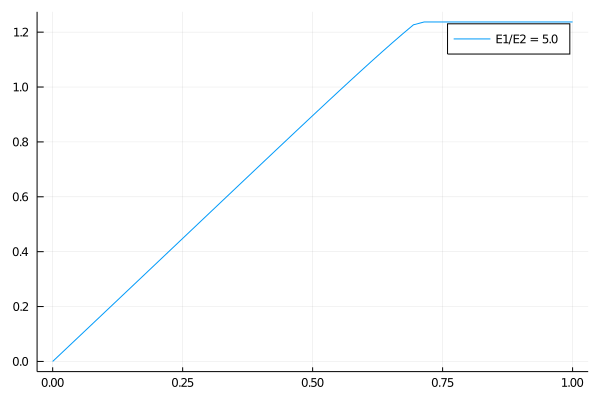

In [65]:
E1 = E_from_KG(K1, G1)
E2 = E_from_KG(K2, G2)
plot(Cs, (E1 .- E0s)./(E1-E2) , label="E1/E2 = $(round(E1/E2))")

In [59]:
println(maximum(E0s))
println(minimum(E0s))
println("E2= $E2")
println("E1= $E1")

805264.8298404777
330211.7132677406
E2= 154285.7142857143
E1= 805264.8298404777


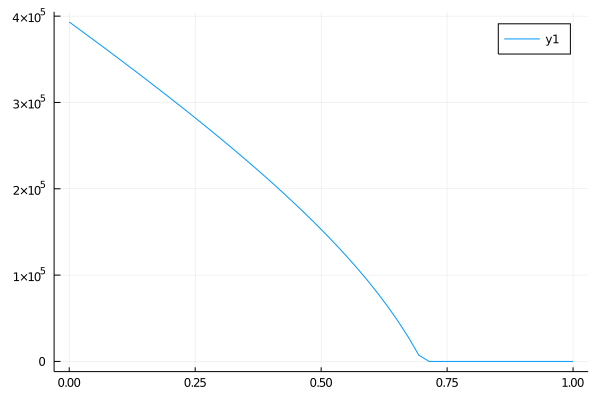

In [81]:
plot(Cs, Ks)

In [80]:
minimum(Gs)

-2.1506511608049993e-79